In [15]:
# Pull data from data file
# Extract X_all and U_all from data file
# Polynomial fit with 5? coeffs in each dimension
# Store coeffs in a separate data file along with train_input


# Separate notebook:
# Create NN to read train_input, train_output (coeffs) and train on them

In [16]:
using Polynomials
using LinearAlgebra
using JLD2, FileIO
using Plots
include("astrobee_se3_script.jl")


LoadError: LoadError: invalid redefinition of constant Astrobee
in expression starting at /home/somrita/Dropbox/Somrita Linux Files/AA290/jlGuSTO/Models/astrobee_se3.jl:3

# Demo of polyfit functionality

In [17]:
x = range(0,stop=2*pi,length=100)
y = map(sin, x)

num_coeffs = 6
p = polyfit(x, y, num_coeffs-1, :t)

@show coeffs(p)

x2 = range(pi,stop=2*pi,length=10)
y2_true = map(sin, x2)
y2_est = polyval(p, x2)
@show y2_true
@show y2_est 
@show (y2_est - y2_true)
norm(y2_est - y2_true)./y2_true

t = range(0,stop=10,length = 100)
y = map(t->0.1, t)
p = polyfit(t,y,5,:t)

coeffs(p) = [0.0128679, 0.871069, 0.276754, -0.397869, 0.0879739, -0.00560059]
y2_true = [1.22465e-16, -0.34202, -0.642788, -0.866025, -0.984808, -0.984808, -0.866025, -0.642788, -0.34202, -2.44929e-16]
y2_est = [1.66187e-15, -0.338049, -0.637441, -0.863005, -0.986533, -0.990267, -0.870382, -0.640465, -0.335005, -0.0128679]
y2_est - y2_true = [1.5394e-15, 0.00397154, 0.00534633, 0.00302031, -0.00172535, -0.00545957, -0.00435631, 0.00232239, 0.00701546, -0.0128679]


Poly(0.10000000000000006 - 9.531213857312475e-17*t + 6.212603408933735e-17*t^2 - 1.6850713204784723e-17*t^3 + 1.9790052158011004e-18*t^4 - 8.281315220670178e-20*t^5)

# Helper functions

In [18]:
function plot_env_and_trajs(model, X_all, labls = [""])
    N = length(X_all)

    idx = [1,2]
    local fig
    fig = plot(framestyle = :box)
    for iter = 1:length(X_all)
        X = X_all[iter]
        plot!(fig, X[1,:], X[2,:];line=(5, :dash), lab = labls[iter])
    end

    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    xlims!((model.x_min[1],model.x_max[1]))
    ylims!((model.x_min[2],model.x_max[2]))
    plot!(leg = true)
    return fig
end

plot_env_and_trajs (generic function with 2 methods)

# How to recover solutions from training data

In [19]:
function getComponentsFromData(train_input, train_output)
    N = 50 
    x_dim = 13
    u_dim = 6
    x_init = train_input[1:x_dim]
    x_final = train_input[x_dim+1:end]
    X_row = train_output[1:x_dim*N]
    X_soln = reshape(X_row, (x_dim,N))
    U_row = train_output[(1+x_dim*N) : end]
    U_soln = reshape(U_row, (u_dim,N-1))
    return x_init, x_final, X_soln, U_soln
end

getComponentsFromData (generic function with 1 method)

In [20]:
function plotCoeffs(coeffs)
    gr(fmt=:png)
    plot()
    plot!(coeffs,
        xlabel = "#",
        ylabel = "coeff",
        legend = :none)
    plot!()
end

plotCoeffs (generic function with 1 method)

# Collect coefficients for all the data

In [22]:
# Get saved data
@load "SimpleAstrobee.jld2" train_input_collected train_output_collected
@show size(train_input_collected)
@show size(train_output_collected)

N = 50
tf_guess = 100.
t_array = range(0,stop=tf_guess,length=N)
t_minus_one_array = t_array[1:end-1]
num_coeffs = 5
num_rows = size(train_input_collected,1)
x_dim = 13
u_dim = 6

all_coeffs = zeros(num_rows, num_coeffs*(x_dim+u_dim))


for row in 1:num_rows
# for row in 1:300
    train_input = train_input_collected[row, :]
    train_output = train_output_collected[row, :]
    x_init_recov, x_final_recov, X_soln_recov, U_soln_recov = getComponentsFromData(train_input, train_output)
    
    # Get fitted polynomial coefficients
    for dim = 1:x_dim
        x_vals = X_soln_recov[dim, :]
        p = polyfit(t_array, x_vals, num_coeffs-1, :t)
        cf = coeffs(p)
        if (size(cf,1) == 1 && cf[1] == 0)
            cf = zeros(num_coeffs)
        end
        all_coeffs[row, ((dim-1)*num_coeffs +1):((dim-1)*num_coeffs +num_coeffs)] = cf
    end
    for dim = 1:u_dim
        u_vals = U_soln_recov[dim, :]
        p = polyfit(t_minus_one_array, u_vals, num_coeffs-1, :t)
        cf = coeffs(p)
        if (size(cf,1) == 1 && cf[1] == 0)
            cf = zeros(num_coeffs)
        end
        all_coeffs[row, (num_coeffs*x_dim + (dim-1)*num_coeffs +1):(num_coeffs*x_dim + (dim-1)*num_coeffs +num_coeffs)] = cf
    end

end
@show size(all_coeffs)
@save "SimpleAstrobeeCoeffs.jld2" train_input_collected all_coeffs
println("Saved the coefficients")


size(train_input_collected) = (5766, 26)
size(train_output_collected) = (5766, 944)
size(all_coeffs) = (5766, 95)
Saved the coefficients


# Plot the coefficients

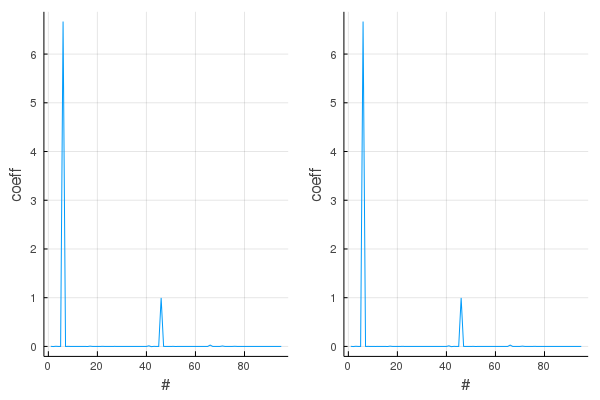

In [24]:
p1 = plotCoeffs(all_coeffs[1,:])
p2 = plotCoeffs(all_coeffs[19,:])
plot(p1,p2)

# Check if the coefficients accurately capture the original data

In [25]:
model = Astrobee()

# Set up environment
model.x_max[1:3] = [10.0; 10.0; 1.0]
model.x_min[1:3] = [0.0; 0.0; 0.0]
model.obstacles = []
obstacles = []
obs = [[0.0,0.0,0.0], 6.0]
push!(obstacles, obs)
obs = [[5.0,5.0,0.0], 1.3]
push!(obstacles, obs)
obs = [[3.0,5.0,0.0], 1.3]
push!(obstacles, obs)
obs = [[5.0,3.0,0.0], 1.3]
push!(obstacles, obs)
model.obstacles = obstacles

model.tf_guess = 110.
model.convergence_threshold = 0.5

N = 50
tf_guess = 100.
t_array = range(0,stop=tf_guess,length=N)
t_minus_one_array = t_array[1:end-1]

0.0:2.0408163265306123:97.95918367346938

# How do the x trajectories compare?

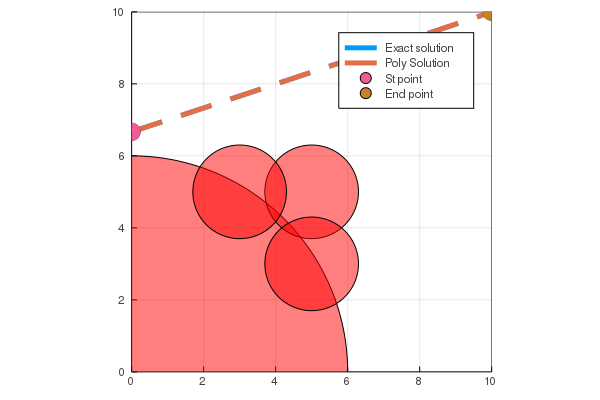

In [26]:
row = 1 # Basic trajectory in straight line

train_input = train_input_collected[row, :]
train_output = train_output_collected[row, :]
x_init_recov, x_final_recov, X_soln_recov, U_soln_recov = getComponentsFromData(train_input, train_output)

cf = all_coeffs[row,:]
cf_x = cf[1:num_coeffs]
cf_y = cf[(num_coeffs+1):(2*num_coeffs)]
x_poly = polyval(Poly(cf_x), t_array)
y_poly = polyval(Poly(cf_y), t_array)
xy_poly = vcat([x_poly', y_poly']...)
plot_env_and_trajs(model, [X_soln_recov, xy_poly],["Exact solution","Poly Solution"])
scatter!((x_init_recov[1],x_init_recov[2]), marker=10, lab="St point")
scatter!((x_final_recov[1],x_final_recov[2]), marker=10, lab="End point")

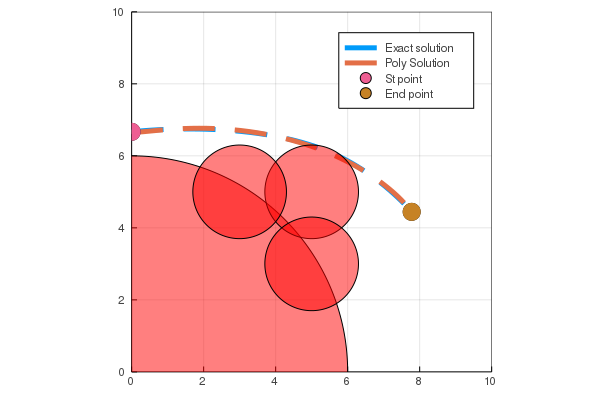

In [27]:
row = 210 # This one is interesting

train_input = train_input_collected[row, :]
train_output = train_output_collected[row, :]
x_init_recov, x_final_recov, X_soln_recov, U_soln_recov = getComponentsFromData(train_input, train_output)

cf = all_coeffs[row,:]
cf_x = cf[1:num_coeffs]
cf_y = cf[(num_coeffs+1):(2*num_coeffs)]
x_poly = polyval(Poly(cf_x), t_array)
y_poly = polyval(Poly(cf_y), t_array)
xy_poly = vcat([x_poly', y_poly']...)
plot_env_and_trajs(model, [X_soln_recov, xy_poly],["Exact solution","Poly Solution"])
scatter!((x_init_recov[1],x_init_recov[2]), marker=10, lab="St point")
scatter!((x_final_recov[1],x_final_recov[2]), marker=10, lab="End point")

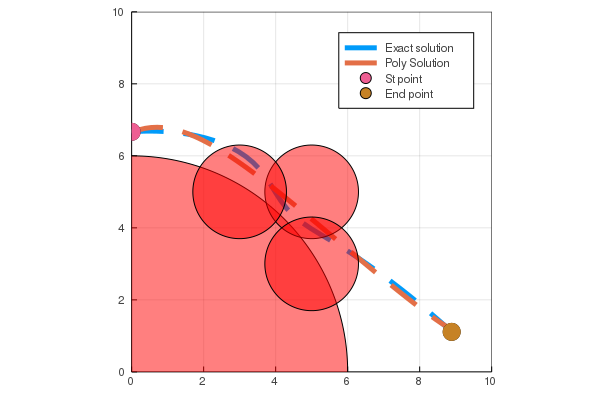

In [28]:
row = 150 # This one is interesting

train_input = train_input_collected[row, :]
train_output = train_output_collected[row, :]
x_init_recov, x_final_recov, X_soln_recov, U_soln_recov = getComponentsFromData(train_input, train_output)

cf = all_coeffs[row,:]
cf_x = cf[1:num_coeffs]
cf_y = cf[(num_coeffs+1):(2*num_coeffs)]
x_poly = polyval(Poly(cf_x), t_array)
y_poly = polyval(Poly(cf_y), t_array)
xy_poly = vcat([x_poly', y_poly']...)
plot_env_and_trajs(model, [X_soln_recov, xy_poly],["Exact solution","Poly Solution"])
scatter!((x_init_recov[1],x_init_recov[2]), marker=10, lab="St point")
scatter!((x_final_recov[1],x_final_recov[2]), marker=10, lab="End point")

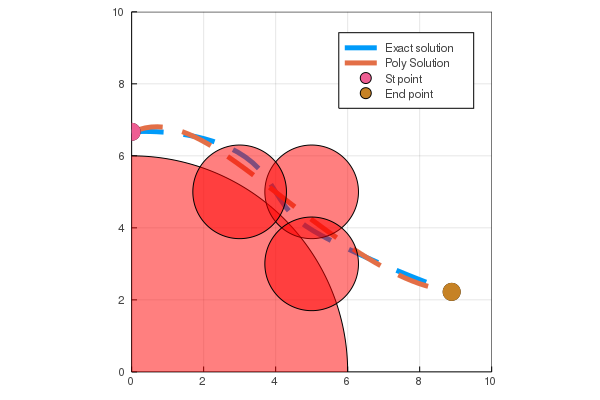

In [31]:
row = 2500 # 

train_input = train_input_collected[row, :]
train_output = train_output_collected[row, :]
x_init_recov, x_final_recov, X_soln_recov, U_soln_recov = getComponentsFromData(train_input, train_output)

cf = all_coeffs[row,:]
cf_x = cf[1:num_coeffs]
cf_y = cf[(num_coeffs+1):(2*num_coeffs)]
x_poly = polyval(Poly(cf_x), t_array)
y_poly = polyval(Poly(cf_y), t_array)
xy_poly = vcat([x_poly', y_poly']...)
plot_env_and_trajs(model, [X_soln_recov, xy_poly],["Exact solution","Poly Solution"])
scatter!((x_init_recov[1],x_init_recov[2]), marker=10, lab="St point")
scatter!((x_final_recov[1],x_final_recov[2]), marker=10, lab="End point")

# How does the u solutions compare?

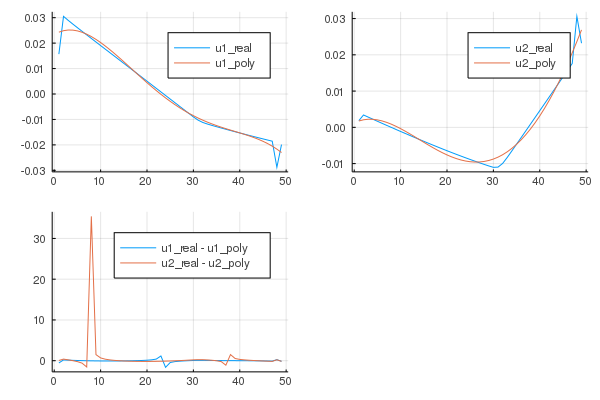

In [164]:
row = 210 # This one is interesting

train_input = train_input_collected[row, :]
train_output = train_output_collected[row, :]
x_init_recov, x_final_recov, X_soln_recov, U_soln_recov = getComponentsFromData(train_input, train_output)

cf = all_coeffs[row,:]
cf_u1 = cf[(num_coeffs*x_dim + 1) : (num_coeffs*x_dim) + num_coeffs]
u1_poly = polyval(Poly(cf_u1), t_minus_one_array)
u1_real = U_soln_recov[1,:]
cf_u2 = cf[(num_coeffs*x_dim + num_coeffs +1) : (num_coeffs*x_dim) + 2*num_coeffs]
u2_poly = polyval(Poly(cf_u2), t_minus_one_array)
u2_real = U_soln_recov[2,:]
gr(fmt=:png)
p1 = plot()
plot!(u1_real, label="u1_real")
plot!(u1_poly, label="u1_poly")
p2 = plot()
plot!(u2_real, label="u2_real")
plot!(u2_poly, label="u2_poly")
p3 = plot()
plot!((u1_real-u1_poly)./u1_real, label="u1_real - u1_poly")
plot!((u2_real-u2_poly)./u2_real, label="u2_real - u2_poly")

plot(p1, p2, p3)

# How does the quaternion solutions compare?

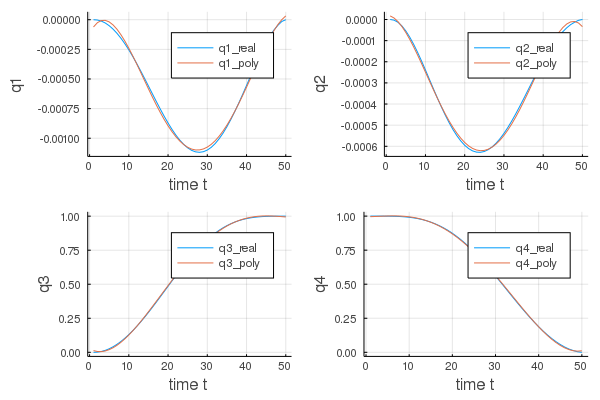

In [165]:
row = 1 # This one is interesting

train_input = train_input_collected[row, :]
train_output = train_output_collected[row, :]
x_init_recov, x_final_recov, X_soln_recov, U_soln_recov = getComponentsFromData(train_input, train_output)

cf = all_coeffs[row,:]


function plotQuaternion(qidx, cf, X_soln_recov, num_coeffs)
    cf_q = cf[(num_coeffs*6 + (qidx-1)*num_coeffs + 1) : (num_coeffs*6 + qidx*num_coeffs)]
    q_poly = polyval(Poly(cf_q), t_array)
    q_real = X_soln_recov[6+qidx,:]
    p1 = plot()
    plot!(q_real, label="q$(qidx)_real")
    plot!(q_poly, label="q$(qidx)_poly", xlabel = "time t", ylabel = "q$(qidx)")
    return p1
end

gr(fmt=:png)
p1 = plotQuaternion(1, cf, X_soln_recov, num_coeffs)
p2 = plotQuaternion(2, cf, X_soln_recov, num_coeffs)
p3 = plotQuaternion(3, cf, X_soln_recov, num_coeffs)
p4 = plotQuaternion(4, cf, X_soln_recov, num_coeffs)
plot(p1,p2, p3, p4)
